In [7]:
import sys
sys.path.append('../deeprl')
import gym
import tensorflow as tf
import tflearn as nn
import numpy as np
#create the environment
env = gym.make('CartPole-v1')




[2017-02-26 19:20:48,884] Making new env: CartPole-v1


First we create a policy network. This network takes an observation as input and returns action porbabilities.

In [2]:
def create_mlp(inputs, n_out):
    net = nn.input_data(placeholder=inputs)
    net = nn.fully_connected(net, 25, activation='relu', weight_decay=0.0001)
    net = nn.dropout(net, 0.3)
    net = nn.fully_connected(net, 25, activation='relu', weight_decay=0.0001)
    net = nn.dropout(net, 0.3)
    #softmax to normalize to probabilities
    net = nn.fully_connected(net, n_out, activation='softmax')
    return net

We can now apply this network to the environment. On every step the network produces action probabilities for the current observation that can be used to select actions

In [12]:
# create a policy network
nn_input = tf.placeholder("float",(None,)+env.observation_space.shape)
n_acts = env.action_space.n
policy = create_mlp(nn_input, env.action_space.n)

# run the network for a single episode
obs = env.reset()
done = False
session = tf.Session()
session.run(tf.global_variables_initializer())
steps = 0
while not done:
    # get action probs for current observation
    act_probs = policy.eval(session=session,feed_dict={nn_input:obs.reshape(1,-1)}).flatten()
    # select action according to probs
    act = np.random.choice(n_acts, p = act_probs)
    #step environment
    obs,rew,done,_ = env.step(act)
    print('step % d reward %f'%(steps,rew))
    steps += 1

step  0 reward 1.000000
step  1 reward 1.000000
step  2 reward 1.000000
step  3 reward 1.000000
step  4 reward 1.000000
step  5 reward 1.000000
step  6 reward 1.000000
step  7 reward 1.000000
step  8 reward 1.000000
step  9 reward 1.000000
step  10 reward 1.000000
step  11 reward 1.000000
step  12 reward 1.000000
step  13 reward 1.000000
step  14 reward 1.000000


As the network uses randomely initialized weights, we cannot expect the resulting policy to perform well. To goal of learning now becomes to adapt the network weights such that the performance of the policy improves. In order to do this, we first define a cost function that we want to optimize:

$$ J(\theta) = E_{\pi_\theta}[R] = \sum_\tau p(\tau \mid \pi_\theta)R(\tau) $$

This cost function indicates we want to optimize the expected return (sum of discounted rewards) for the policy. Here $\pi_\theta$ is the policy represented by the network with weights $\theta$, $p(\tau \mid \pi_\theta)$ is the probability of observing a trajectory (episode)  $\tau= s_0,a_0,s_1,a_t,...,s_T$ when applying this policy and $R(\tau)$ is the return for this trajectory, ie $R = \sum_{t=0}^T \gamma^t r_{t+1}$. Changing our policy changes the probability $p$ of achieving a trajectory, so essentially this cost says that we want to change the policy in such a way that the probability of trajectories which have a high return increases.

In order to optimize this cost function, we calculate the gradient w.r.t. the network weights:

$$\nabla_\theta J(\theta) = \nabla_\theta \sum_\tau p(\tau \mid \pi_\theta)R(\tau) = \sum_\tau \nabla_\theta p(\tau \mid \pi_\theta)R(\tau)$$

 Using 
$\nabla_\theta p(\tau \mid \pi_\theta) = \frac{p(\tau \mid \pi_\theta)}{p(\tau \mid \pi_\theta)} \nabla_\theta p(\tau \mid \pi_\theta)$ and $\nabla_\theta log p(\tau \mid \pi_\theta) = \frac{1}{p(\tau \mid \pi_\theta)}\nabla_\theta p(\tau \mid \pi_\theta)$ we can rewrite this as:

$$ \sum_\tau  p(\tau \mid \pi_\theta) \nabla_\theta log p(\tau \mid \pi_\theta) R(\tau)$$
$$ = E_{\pi_\theta}[ \nabla_\theta log p(\tau \mid \pi_\theta) R(\tau) ] $$

Where $E_{\pi_\theta}$ is an expectation over trajectories generated by the policy. This means we can sample this expectation by running the policy and averaging over the generated trajectories. 

Moreover, we do not actually need to compute the the probability $p(\tau \mid \pi_\theta)$ of a trajectory. This probability of $\tau= s_0,a_0,s_1,a_t,...,s_T$ is $\prod _{t=0}^T T(s_t,a_t,s_{t+1}) \pi_\theta(s_t,a_t)$, where $T(s_0,a_0,s_1)$ are the transition probabilities of the MDP. Since $T$ does not depend on the network weights, we only have to look at $\pi$ to compute the gradient $ \nabla_\theta log p(\tau \mid \pi_\theta)$:

$$\nabla_\theta log p(\tau \mid \pi_\theta)= \nabla_\theta log \prod _{t=0}^T \pi_\theta(s_t,a_t)T(s_t,a_t,s_{t+1}) \\
= \sum_{t=0}^T \nabla_\theta  log \pi_\theta(s_t,a_t) $$

This results in the final formula $\nabla_\theta J(\theta) = E_{\pi_\theta}[ \sum_{t=0}^T \nabla_\theta  log \pi_\theta(s_t,a_t) R(\tau) ]$, i.e. to compute the policy gradient from a trajectory, we sum over the log of the action probabilities output by the network and multiply by the return. 


This results in the Monte Carlo Policy gradient (REINFORCE) algorithm:
![reinforce](pg.png)


In tensorflow this can be implemented by defining the following loss:

   ** loss_op = -tf.reduce_mean(tf.log(probs) * R)**
    
where probs is the output of the network for the selected actions for each time step and R is the return (here: sum of discounted rewards) starting from that time step. Here we take a mean over time steps rather than a sum. This helps with variations in magnitude because trajectories can have very different lengths.

You can run the full policy gradient algorithm using the DPGAgent:

In [14]:
from agents import DPGAgent
from experiment import Experiment

#erase previously created tf graphs
tf.reset_default_graph()

#create a DQNAgent
agent = DPGAgent(create_mlp, env.action_space.n, env.observation_space.shape, alpha=0.001, gamma=0.99)
# create experiment on cartpole
exp = Experiment(agent, env)
#run agent for 150K steps and return episode rewards
rew = exp.run_epoch(150000)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-02-26 20:18:37,257] From ../deeprl/agents.py:224: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


episode reward: 15.000000
episode reward: 20.000000
episode reward: 18.000000
episode reward: 29.000000
episode reward: 14.000000
episode reward: 35.000000
episode reward: 11.000000
episode reward: 9.000000
episode reward: 12.000000
episode reward: 21.000000
episode reward: 20.000000
episode reward: 20.000000
episode reward: 33.000000
episode reward: 17.000000
episode reward: 32.000000
episode reward: 26.000000
episode reward: 20.000000
episode reward: 22.000000
episode reward: 38.000000
episode reward: 25.000000
episode reward: 11.000000
episode reward: 14.000000
episode reward: 10.000000
episode reward: 16.000000
episode reward: 15.000000
episode reward: 63.000000
episode reward: 44.000000
episode reward: 17.000000
episode reward: 20.000000
episode reward: 12.000000
episode reward: 19.000000
episode reward: 15.000000
episode reward: 13.000000
episode reward: 12.000000
episode reward: 17.000000
episode reward: 25.000000
episode reward: 45.000000
episode reward: 11.000000
episode rewar

<Container object of 2402 artists>

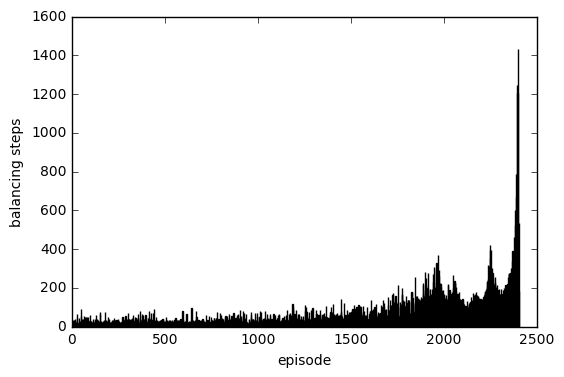

In [28]:
# plot the episode rewards (balancing steps)
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('episode')
plt.ylabel('balancing steps')
plt.bar(np.arange(len(rew)),rew)

 # Assignment
 1. Adapt the create_mlp function to try different network architectures. You  can experiment with different depths (more layers) , different sizes (more nodes/layer) or regularization (weight decay/dropout).
 2. Try different combinations of learning rate (alpha) and discount (gamma). Plot the results to see which gives the best results.
 3.  **(Advanced - optional)**: Try improving the learning agent's performance by adding a critic. A critic evaluates the learning agent by estimating the Q-values of the current policy. You can train a critic by training a second network to predict Q-values. This network takes as inputs the observations and outputs Q-values. You can train it using the same observations and returns as used in standard PG with target $\frac{1}{T}\sum_{t=0}^{T}(Q_\omega(s_t,a_t) - R_t)^2$ where $Q_\omega(s_t,a_t)$ is the output Q-value predicted by the network for the action that was taken at time $t$ and $R_t$ is the return achieved (same as in the cost function above). The policy gradient target then becomes $ - \frac{1}{T}\sum_{t=0}^{T} log \pi_\theta(s_t,a_t) Q_\omega(s_t,a_t)$ (replace R with Q) where $\pi_\theta(s_t,a_T)$ is the action probability output by the first network and $Q_\omega(s_t,a_t)$ are the action Q-values predicted by the second network. In practice, people often use a single network with 2 output layers, 1 for probabilities and 1 for Q-values. More details: http://www0.cs.ucl.ac.uk/staff/D.Silver/web/Teaching_files/pg.pdf